# Malaria

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import preprocessing as prepro
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from imblearn.over_sampling import SMOTE
from collections import Counter

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
estimated = pd.read_csv('estimated_numbers.csv')
incidence = pd.read_csv('incidence_per_1000_pop_at_risk.csv')
reported = pd.read_csv('reported_numbers.csv')
test = incidence[:107]

In [6]:
reported

,Country,Year,No. of cases,No. of deaths,WHO Region
0,Afghanistan,2017,161778.0,10.0,Eastern Mediterranean
1,Algeria,2017,0.0,0.0,Africa
2,Angola,2017,3874892.0,13967.0,Africa
3,Argentina,2017,0.0,1.0,Americas
4,Armenia,2017,0.0,NaN,Europe
...,...,...,...,...,...
1939,Venezuela (Bolivarian Republic of),2000,29736.0,24.0,Americas
1940,Viet Nam,2000,74316.0,142.0,Western Pacific
1941,Yemen,2000,1394495.0,NaN,Eastern Mediterranean
1942,Zambia,2000,NaN,NaN,Africa


# Feature engineering

### Get dummies has been applied to the 'Country' feature of the reported data, thereby one hot encoding it.

In [13]:
reported = pd.concat([reported, pd.get_dummies(reported['Country'])], axis=1)

### We use a Label Encoder to convert the 'Country' and 'WHO Region' features from categorical to numerical.

In [14]:
cols = ['Country', 'WHO Region']
for col in cols:
    le = LabelEncoder()
    letest = LabelEncoder()
    reported[col] = le.fit_transform(reported[col])

### Now, an incidence feature is added to the reported data, followed by binning the cases and incidence features.

In [15]:
reported['Incidence'] = (incidence['No. of cases'][107:]).reset_index(drop=True)
reported['Cases bin'] = pd.cut(reported['No. of cases'], bins=[0, 100, 1000, 10000, 100000, 1000000, 16000000], labels=[0, 1, 2, 3, 4, 5]).fillna(0)
reported['Incidence bin'] = pd.cut(reported['Incidence'], bins=[0, 0.3, 5, 45, 250, 800], labels=[0, 1, 2, 3, 4]).fillna(0)
reported = reported.fillna(0)

### Next, log transform and box cox features have been added to the reported dataframe.

In [16]:
reported['Log no. of cases'] = (reported['No. of cases']+1).transform(np.log)
reported['Box Cox no. of cases'] = stats.boxcox(reported['No. of cases']+1)[0]

reported['Log WHO Region'] = (reported['WHO Region']+1).transform(np.log)
reported['Box Cox WHO Region'] = stats.boxcox(reported['WHO Region']+1)[0]

reported['Log Incidence'] = (reported['Incidence']+1).transform(np.log)
reported['Box Cox Incidence'] = stats.boxcox(reported['Incidence']+1)[0]

### We also add a minmax, standardized and normalized set of variables.

In [17]:
reported['Cases minmax'] = prepro.minmax_scale(reported[['No. of cases']])
reported['Cases standardized'] = prepro.StandardScaler().fit_transform(reported[['No. of cases']])
reported['Cases l2'] = prepro.normalize(reported[['No. of cases']])

reported['Incidence minmax'] = prepro.minmax_scale(reported[['Incidence']])
reported['Incidence standardized'] = prepro.StandardScaler().fit_transform(reported[['Incidence']])
reported['Incidence l2'] = prepro.normalize(reported[['Incidence']])

In [18]:
y = reported['No. of deaths']
X = reported.drop('No. of deaths', axis=1).reset_index(drop=True)

# Data visualisation

### Afterwards, we must now visualise our new feature engineered data with comparison to their original.

### Firstly, we look at the binned data which has come from the cases and incidence features.

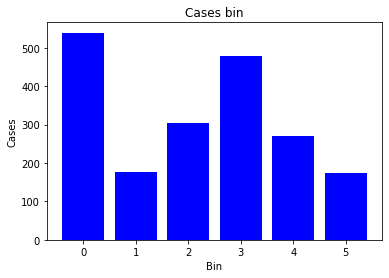

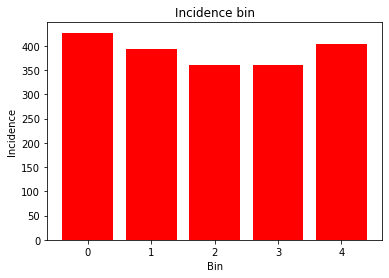

In [19]:
count=Counter(reported['Cases bin'])
plt.bar(count.keys(), count.values(), color='blue')
plt.title('Cases bin')
plt.ylabel('Cases')
plt.xlabel('Bin')
plt.show()

count=Counter(reported['Incidence bin'])
plt.bar(count.keys(), count.values(), color='red')
plt.title('Incidence bin')
plt.ylabel('Incidence')
plt.xlabel('Bin')
plt.show()

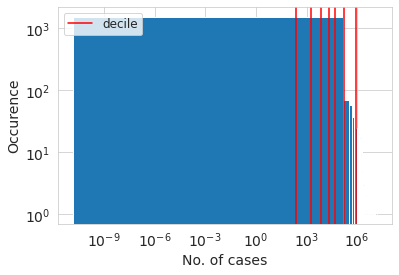

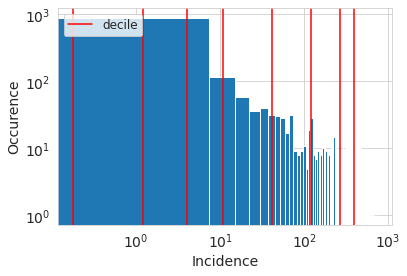

In [20]:
cases_decile = reported['No. of cases'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1)
reported['No. of cases'].hist(ax=ax, bins=100)
for pos in cases_decile:
    handle = plt.axvline(pos, color='r')
    
ax.legend([handle], ['decile'], fontsize=12)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('No. of cases', fontsize=14)
ax.set_ylabel('Occurence', fontsize=14)
plt.show()

incidence_decile = reported['Incidence'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1)
reported['Incidence'].hist(ax=ax, bins=100)
for pos in incidence_decile:
    handle = plt.axvline(pos, color='r')
    
ax.legend([handle], ['decile'], fontsize=12)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Incidence', fontsize=14)
ax.set_ylabel('Occurence', fontsize=14)
plt.show()

### Secondly, the log transform and box cox of our X is visualised and compared to the original data.
### This is done for the cases, WHO Region and incidence features.

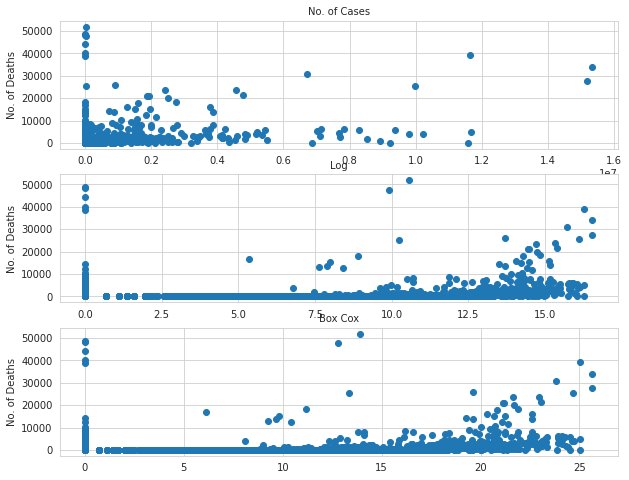

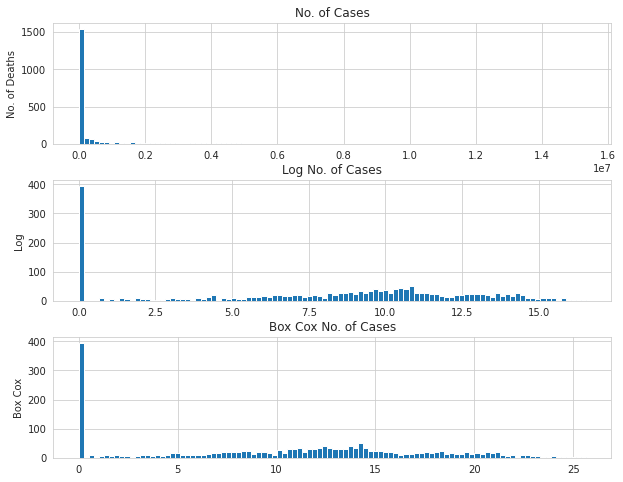

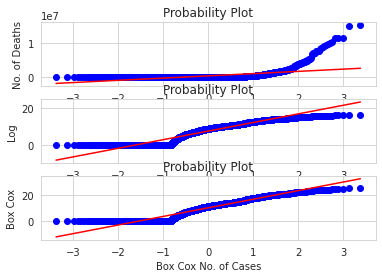

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

ax1.scatter(X['No. of cases'], y)
ax1.set_title('No. of Cases', fontsize=10)
ax1.set_ylabel('No. of Deaths', fontsize=10)

ax2.scatter(X['Log no. of cases'], y)
ax2.set_title('Log', fontsize=10)
ax2.set_ylabel('No. of Deaths', fontsize=10)

ax3.scatter(stats.boxcox(reported['No. of cases']+1)[0], y)
ax3.set_title('Box Cox', fontsize=10)
ax3.set_ylabel('No. of Deaths', fontsize=10)

plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

X['No. of cases'].hist(ax=ax1, bins=100)
ax1.set_title('No. of Cases')
ax1.set_ylabel('No. of Deaths')

X['Log no. of cases'].hist(ax=ax2, bins=100)
ax2.set_title('Log No. of Cases')
ax2.set_ylabel('Log')

pd.DataFrame(stats.boxcox(reported['No. of cases']+1)[0]).hist(ax=ax3, bins=100)
ax3.set_title('Box Cox No. of Cases')
ax3.set_ylabel('Box Cox')

plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

prob1 = stats.probplot(X['No. of cases'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('No. of Cases')
ax1.set_ylabel('No. of Deaths')

prob2 = stats.probplot(X['Log no. of cases'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('Log No. of Cases')
ax2.set_ylabel('Log')

prob3 = stats.probplot(stats.boxcox(reported['No. of cases']+1)[0], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Box Cox No. of Cases')
ax3.set_ylabel('Box Cox')

plt.show()

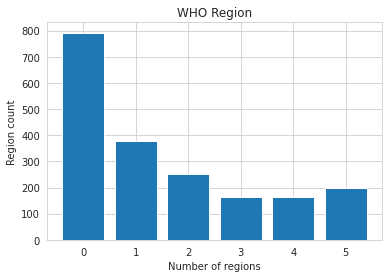

In [22]:
count = Counter(X['WHO Region'])
plt.bar(count.keys(), count.values())
plt.title('WHO Region')
plt.xlabel('Number of regions')
plt.ylabel('Region count')
plt.show()

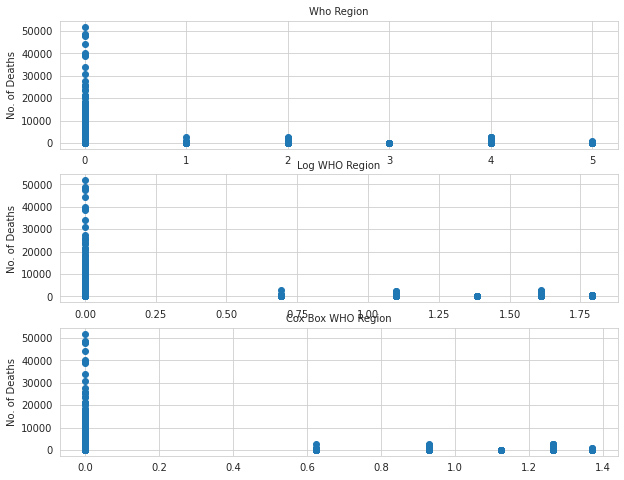

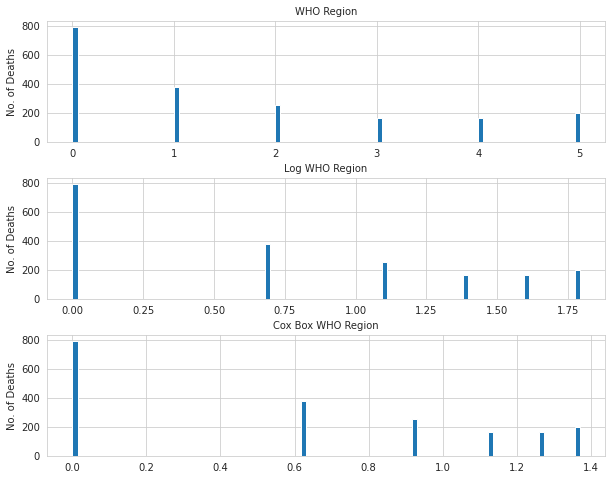

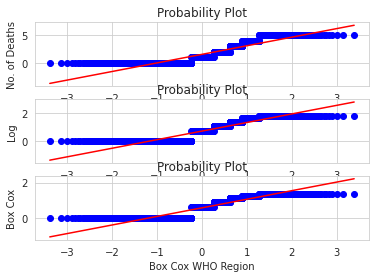

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

ax1.scatter(X['WHO Region'], y)
ax1.set_title('Who Region', fontsize=10)
ax1.set_ylabel('No. of Deaths', fontsize=10)

ax2.scatter(X['Log WHO Region'], y)
ax2.set_title('Log WHO Region', fontsize=10)
ax2.set_ylabel('No. of Deaths', fontsize=10)

ax3.scatter(stats.boxcox(X['WHO Region']+1)[0], y)
ax3.set_title('Cox Box WHO Region', fontsize=10)
ax3.set_ylabel('No. of Deaths', fontsize=10)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

X['WHO Region'].hist(ax=ax1, bins=100)
ax1.set_title('WHO Region', fontsize=10)
ax1.set_ylabel('No. of Deaths', fontsize=10)

X['Log WHO Region'].hist(ax=ax2, bins=100)
ax2.set_title('Log WHO Region', fontsize=10)
ax2.set_ylabel('No. of Deaths', fontsize=10)

pd.DataFrame(stats.boxcox(X['WHO Region']+1)[0]).hist(ax=ax3, bins=100)
ax3.set_title('Cox Box WHO Region', fontsize=10)
ax3.set_ylabel('No. of Deaths', fontsize=10)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

prob1 = stats.probplot(X['WHO Region'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('WHO Region')
ax1.set_ylabel('No. of Deaths')

prob2 = stats.probplot(X['Log WHO Region'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('Log WHO Region')
ax2.set_ylabel('Log')

prob3 = stats.probplot(stats.boxcox(reported['WHO Region']+1)[0], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Box Cox WHO Region')
ax3.set_ylabel('Box Cox')

plt.show()

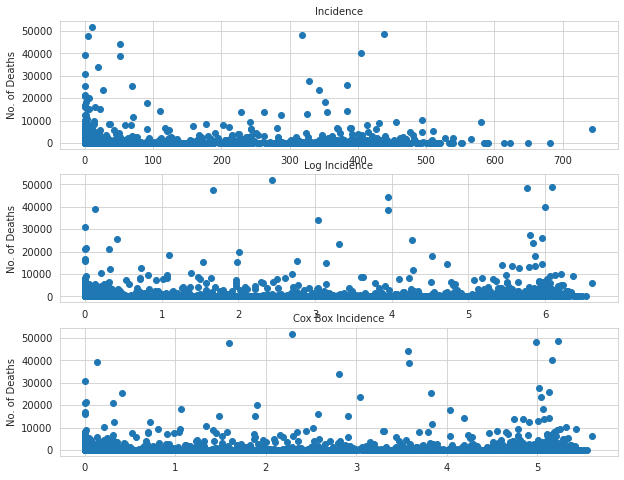

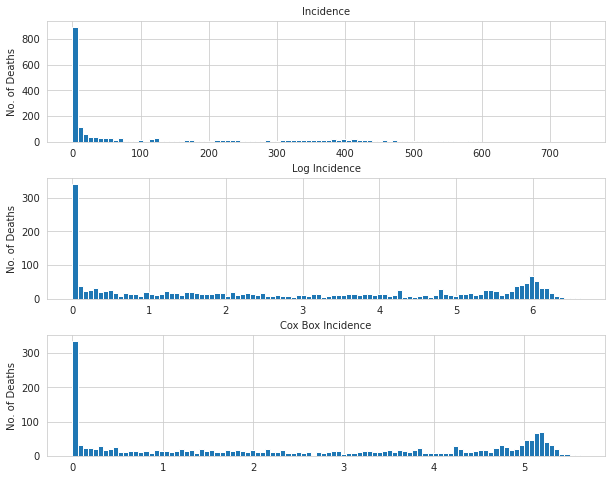

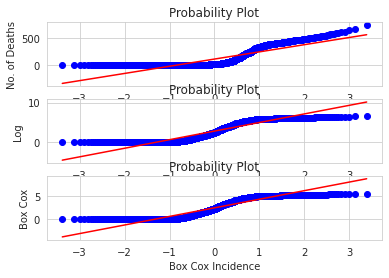

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

ax1.scatter(X['Incidence'], y)
ax1.set_title('Incidence', fontsize=10)
ax1.set_ylabel('No. of Deaths', fontsize=10)

ax2.scatter(X['Log Incidence'], y)
ax2.set_title('Log Incidence', fontsize=10)
ax2.set_ylabel('No. of Deaths', fontsize=10)

ax3.scatter(stats.boxcox(X['Incidence']+1)[0], y)
ax3.set_title('Cox Box Incidence', fontsize=10)
ax3.set_ylabel('No. of Deaths', fontsize=10)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

X['Incidence'].hist(ax=ax1, bins=100)
ax1.set_title('Incidence', fontsize=10)
ax1.set_ylabel('No. of Deaths', fontsize=10)

X['Log Incidence'].hist(ax=ax2, bins=100)
ax2.set_title('Log Incidence', fontsize=10)
ax2.set_ylabel('No. of Deaths', fontsize=10)

pd.DataFrame(stats.boxcox(X['Incidence']+1)[0]).hist(ax=ax3, bins=100)
ax3.set_title('Cox Box Incidence', fontsize=10)
ax3.set_ylabel('No. of Deaths', fontsize=10)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

prob1 = stats.probplot(X['Incidence'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('Incidence')
ax1.set_ylabel('No. of Deaths')

prob2 = stats.probplot(X['Log Incidence'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('Log Incidence')
ax2.set_ylabel('Log')

prob3 = stats.probplot(stats.boxcox(reported['Incidence']+1)[0], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Box Cox Incidence')
ax3.set_ylabel('Box Cox')

plt.show()

In [31]:
X['Cases bin'] = X['Cases bin'].astype('float64')
X['Incidence bin'] = X['Incidence bin'].astype('float64')

### In preperation for inputting the X and y to our model, we must first split it into train and val sets.
### After that, the X_train and X_val are scaled with a min max scaler.

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = prepro.minmax_scale(X_train)
X_val = prepro.minmax_scale(X_val)

In [35]:
X_train.shape

(1555, 235)

In [38]:
X_val.shape

(389, 235)

# Model prediction

### We have created a Multilayer Perceptron with 3 hidden layers, 3 dropouts which have a dropout rate of 0.325 and an output activation of sigmoid. The loss is a binary cross entropy and the optimizer is an Adam which has a learning rate of 0.0001 and an epsilon of 2e-06.

Epoch 1/98
100/100 [==============================] - 2s 7ms/step - loss: -556.5018 - accuracy: 0.2358 - val_loss: 22.4531 - val_accuracy: 0.1697
Epoch 2/98
100/100 [==============================] - 0s 4ms/step - loss: -5618.7097 - accuracy: 0.2777 - val_loss: -115.5198 - val_accuracy: 0.2828
Epoch 3/98
100/100 [==============================] - 0s 4ms/step - loss: -10852.7425 - accuracy: 0.2859 - val_loss: -869.1539 - val_accuracy: 0.2879
Epoch 4/98
100/100 [==============================] - 0s 4ms/step - loss: -16225.4277 - accuracy: 0.2801 - val_loss: -2991.2202 - val_accuracy: 0.2828
Epoch 5/98
100/100 [==============================] - 0s 4ms/step - loss: -19401.3727 - accuracy: 0.3005 - val_loss: -6436.4692 - val_accuracy: 0.2776
Epoch 6/98
100/100 [==============================] - 0s 4ms/step - loss: -24797.5836 - accuracy: 0.2967 - val_loss: -9958.7715 - val_accuracy: 0.2776
Epoch 7/98
100/100 [==============================] - 0s 5ms/step - loss: -25840.2566 - accuracy: 0.29

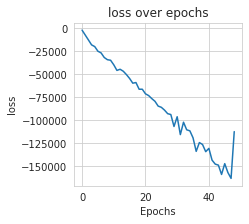

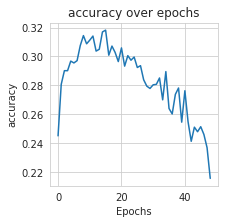

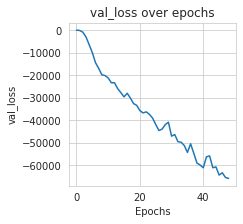

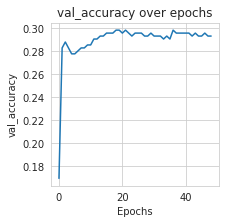

In [40]:
model = Sequential()

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1.0), kernel_initializer='RandomUniform', input_dim=235))
model.add(BatchNormalization())
model.add(Dropout(0.325))

model.add(Dense(86, activation='relu', kernel_regularizer=l2(1.0), kernel_initializer='RandomUniform'))
model.add(BatchNormalization())
model.add(Dropout(0.325))

model.add(Dense(58, activation='relu', kernel_regularizer=l2(1.0), kernel_initializer='RandomUniform'))
model.add(BatchNormalization())
model.add(Dropout(0.325))

model.add(Dense(1, activation='sigmoid'))

model.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer=Adam(lr=0.0001, epsilon=2e-06))
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=98, batch_size=32, steps_per_epoch=100)

for j in history.history:
    plt.figure(figsize=(3, 3))
    plt.xlabel('Epochs')
    plt.ylabel(j)
    plt.title(j + ' over epochs')
    plt.plot(history.history[j])
    plt.show()

In [41]:
score = model.evaluate(X_val, y_val)
print('Accuracy: ' + str(score[1]) + ' Loss: ' + str(score[0]))

13/13 [==============================] - 0s 2ms/step - loss: -65862.6797 - accuracy: 0.2931
Accuracy: 0.2930591404438019 Loss: -65862.6796875
